In [4]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import re
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import warnings
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Downloading stuff from nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
# Suppress specific performance warnings
warnings.filterwarnings('ignore', message='DataFrame is highly fragmented')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [6]:
# Loading Data
ds = load_dataset("David-Egea/phishing-texts")
df = ds['train'].to_pandas()
df['text'] = df['text'].astype(str)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.90k [00:00<?, ?B/s]

dataset.json:   0%|          | 0.00/52.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20301 [00:00<?, ? examples/s]

In [7]:
data = df[df['text'].str.len() > 15_000_000]['text'].iloc[0]
df = df[df['text'].str.len() <= 15_000_000]
emails_and_labels = re.split(r'\",([01]) \d+,\"', data)[1:]  # Split and ignore the first empty result from split
emails_and_labels = [email.strip() for email in emails_and_labels]  # Strip extra spaces and new lines

df_anomalous = pd.DataFrame({
    'phishing': [int(y) for y in emails_and_labels[::2]],
    'text': [email for email in emails_and_labels[1::2]]
})

In [8]:
print(f"Shape before adding the rows from the anomalous row: {df.shape}")
df = pd.concat([df, df_anomalous], axis=0, ignore_index=True)
print(f"Shape after adding the rows from the anomalous row: {df.shape}")

Shape before adding the rows from the anomalous row: (20300, 2)
Shape after adding the rows from the anomalous row: (25509, 2)


In [9]:
df['text_length'] = df['text'].apply(len)
df['cleaned_text'] = df['text'].apply(clean_text).apply(remove_stop_words).apply(remove_NUM)

def word_count_no_punc(text):
    text_clean = re.sub(r'[^\w\s]', '', text)
    tokens = text_clean.split()
    return len(tokens)

df['word_count_with_stop_words'] = df['text'].apply(clean_text).apply(remove_NUM).apply(word_count_no_punc)

df['word_count_without_stop_words'] = df['text'].apply(clean_text).apply(remove_stop_words).apply(remove_NUM).apply(word_count_no_punc)

def count_punc(text):
    non_word_matches = re.findall(r'[^\w\s]', text)
    return len(non_word_matches)

df['special_punc_count'] = df['cleaned_text'].apply(count_punc)

def has_email(text):
    if 'EMAIL' in text:
        return 1
    else:
        return 0

df['has_email'] = df['cleaned_text'].apply(has_email)

def has_number(text):
    if 'NUM' in text:
        return 1
    else:
        return 0

df['has_num'] = df['text'].apply(clean_text).apply(remove_stop_words).apply(has_number)

df['capital_letter_ratio'] = df['text'].apply(clean_text_no_lower).apply(remove_stop_words).apply(remove_NUM).apply(
    lambda x: sum(1 for char in x if char.isupper())/len(x) if len(x) > 0 else 0
)

def analyze_protocols(text):
    """Analyze HTTP and HTTPS protocols in text."""
    if not isinstance(text, str):
        return 0, 0

    http_count = len(re.findall(r'http://\S+', text))
    https_count = len(re.findall(r'https://\S+', text))

    return http_count, https_count

df[['http_count', 'https_count']] = df['text'].apply(lambda x: pd.Series(analyze_protocols(x)))

df['has_http'] = (df['http_count'] > 0).astype(int)
df['has_https'] = (df['https_count'] > 0).astype(int)

def contains_url(text):
    """Check if text contains a URL pattern."""
    return int(bool(re.search(r'http[s]?://\S+', str(text)))) if isinstance(text, str) else False

def count_urls(text):
    """Count number of URLs in text."""
    return len(re.findall(r'http[s]?://\S+', str(text))) if isinstance(text, str) else 0

df[['has_url', 'url_count']] = df['text'].apply(lambda x: pd.Series([contains_url(x), count_urls(x)]))

final_df = df.copy()

In [10]:
X = final_df.drop('phishing', axis=1)
y = final_df['phishing']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=3)

In [12]:
get_text = FunctionTransformer(lambda X: X['cleaned_text'], validate=False)

tfidf_pipeline = Pipeline([
    ('extract', get_text),
    ('tfidf', TfidfVectorizer()),
    ('svd', TruncatedSVD(n_components=10))
])

other_columns = ['text_length', 'word_count_with_stop_words', 'word_count_without_stop_words',
                'special_punc_count', 'has_email', 'has_num', 'capital_letter_ratio',
                'http_count', 'https_count', 'has_http', 'has_https', 'has_url', 'url_count']

preprocessor = ColumnTransformer([
    ('text', tfidf_pipeline, ['cleaned_text']),
    ('others', 'passthrough', other_columns)
])

random_forest_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100))
])

scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(random_forest_pipeline, X_train_val, y_train_val, cv=cv, scoring=scoring)

print("\nCross-Validation Results:")
print(f"Average Accuracy: {np.mean(cv_results['test_accuracy']):.4f}")
print(f"Average Recall: {np.mean(cv_results['test_recall']):.4f}")
print(f"Average Precision: {np.mean(cv_results['test_precision']):.4f}")
print(f"Average F1-Score: {np.mean(cv_results['test_f1']):.4f}")

import time
print(f"\nTraining set size: {len(X_train_val)}, Test set size: {len(X_test)}")

start = time.time()
random_forest_pipeline.fit(X_train_val, y_train_val)
training_time = time.time() - start
print(f'Training Time: {training_time:.2f}s')

start = time.time()
preds = random_forest_pipeline.predict(X_test)
prediction_time = time.time() - start
print(f'Prediction Time: {prediction_time:.2f}s')

print("\nTest Set Results:")
print(f"Accuracy: {accuracy_score(y_test, preds):.4f}")
print(f"Recall: {recall_score(y_test, preds):.4f}")
print(f"Precision: {precision_score(y_test, preds):.4f}")
print(f"F1-Score: {f1_score(y_test, preds):.4f}")


Cross-Validation Results:
Average Accuracy: 0.9632
Average Recall: 0.9375
Average Precision: 0.9524
Average F1-Score: 0.9449

Training set size: 20407, Test set size: 5102
Training Time: 14.79s
Prediction Time: 0.86s

Test Set Results:
Accuracy: 0.9702
Recall: 0.9528
Precision: 0.9584
F1-Score: 0.9556


<Figure size 800x600 with 0 Axes>

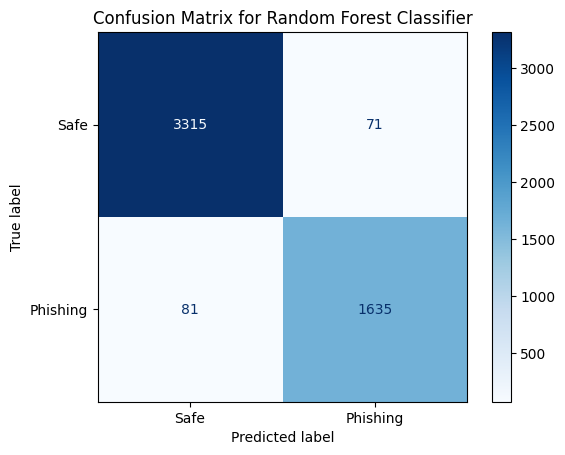

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Safe', 'Phishing'])

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()